# ALS Project
This project will have you work on the same dataset as the other recommendation project, except this time we will use the ALS recommender with Spark.

Load the following dataset : ```http://www.occamslab.com/petricek/data/ratings.dat```

The dataset is very big, more than 17 million entries. Try and train a model with a small subset of user ids and then scale up that number in order to measure changes in term of prediction errors.

1. Import libraries :

In [1]:
!pip install pyspark

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql import functions as F

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer


2. Define a SparkSession object

In [3]:
conf = SparkConf().setMaster("local")

In [4]:
sc = SparkContext(conf=conf)

In [5]:
spark = SparkSession(sc)

3. Load the following dataset : ```http://www.occamslab.com/petricek/data/ratings.dat```

In [27]:
ratings = pd.read_csv("http://www.occamslab.com/petricek/data/ratings.dat", header=None)
ratings.columns=["UserID", "ProfileID", "Rating"]
sample_ID = ratings["UserID"].sample(100000)
rows_to_keep = ratings["UserID"].isin(sample_ID)
ratings = ratings.loc[rows_to_keep,:]
ratings.head()

,UserID,ProfileID,Rating
345,2,133,10
346,2,4340,8
347,2,4672,10
348,2,5577,10
349,2,7006,10


In [28]:
ratings.shape

(11783581, 3)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


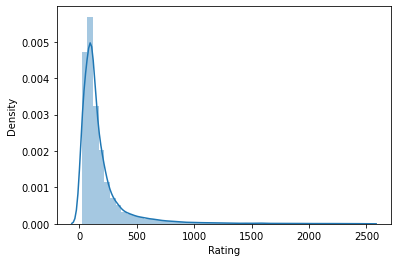

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(ratings.groupby("UserID").count()["Rating"][ratings.groupby("UserID").count()["Rating"]<2500])

In [50]:
pd.DataFrame(ratings.groupby("UserID").count()["Rating"]).describe()

,Rating
count,50826.000000
mean,231.841597
std,599.087803
min,20.000000
25%,74.000000
50%,117.000000
75%,207.000000
max,25042.000000


4. Transform the dataset into a Spark DataFrame and call it rating

In [7]:
rating = spark.createDataFrame(ratings)

In [8]:
rating.limit(10).toPandas()

,UserID,ProfileID,Rating
0,1,133,8
1,1,720,6
2,1,971,10
3,1,1095,7
4,1,1616,10
5,1,1978,7
6,1,2145,8
7,1,2211,8
8,1,3751,7
9,1,4062,3


#1. Pre processing

#2. Entrainement

1. Split the data between train and test

In [9]:

train, test = rating.randomSplit([0.8, 0.2])

2. Create an instance of the ALS model and try and find the best rank for the implicit variables space thanks to a cross-validator.

In [10]:
als = ALS(userCol="UserID", itemCol="ProfileID", ratingCol="Rating", coldStartStrategy="drop", nonnegative=True)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")

paramGrid = ParamGridBuilder() \
                    .addGrid(als.rank, [5, 10, 20]) \
                    .addGrid(als.maxIter,[5]) \
                    .build()

cv = CrossValidator(
  estimator=als, 
  evaluator=evaluator, 
  estimatorParamMaps=paramGrid, 
  numFolds=5
)

3. Fit the model

In [11]:
%time model = cv.fit(train)

CPU times: user 2.23 s, sys: 466 ms, total: 2.69 s
Wall time: 24min 22s


#3. Evaluation et analyse

1. Create an object predictions_test that contains the predictions of the model for the test set.

In [12]:
predictions_test = model.transform(test)

In [13]:
predictions_test.limit(10).toPandas()

,UserID,ProfileID,Rating,prediction
0,4100,496,10,8.707150
1,53343,496,7,7.716342
2,129820,496,6,7.772081
3,133751,496,7,6.082697
4,48711,1238,1,3.984700
5,35899,1238,1,5.007784
6,42017,1238,6,4.923349
7,55648,1238,10,7.409413
8,90280,1238,5,2.192980
9,101603,1238,1,2.443280


In [14]:
evaluator.evaluate(predictions_test.select(F.col("Rating"), F.col("prediction")))

1.848212846784886

In [15]:
mae = RegressionEvaluator(metricName="mae", labelCol="Rating", predictionCol="prediction")

mae.evaluate(predictions_test.select(F.col("Rating"), F.col("prediction")))

1.3045357958899797

#10k sample

3. Load the following dataset : ```http://www.occamslab.com/petricek/data/ratings.dat```

In [16]:
ratings = pd.read_csv("http://www.occamslab.com/petricek/data/ratings.dat", header=None)
ratings.columns=["UserID", "ProfileID", "Rating"]
sample_ID = ratings["UserID"].sample(10000)
rows_to_keep = ratings["UserID"].isin(sample_ID)
ratings = ratings.loc[rows_to_keep,:]
ratings.head()

,UserID,ProfileID,Rating
8465,60,425,2
8466,60,437,10
8467,60,538,6
8468,60,2250,1
8469,60,2294,5


In [26]:
ratings.shape

(4594276, 3)

4. Transform the dataset into a Spark DataFrame and call it rating

In [17]:
rating = spark.createDataFrame(ratings)

In [18]:
rating.limit(10).toPandas()

,UserID,ProfileID,Rating
0,60,425,2
1,60,437,10
2,60,538,6
3,60,2250,1
4,60,2294,5
5,60,2393,6
6,60,2524,5
7,60,3454,4
8,60,4860,10
9,60,5209,10


#1. Pre processing

#2. Entrainement

1. Split the data between train and test

In [19]:

train, test = rating.randomSplit([0.8, 0.2])

2. Create an instance of the ALS model and try and find the best rank for the implicit variables space thanks to a cross-validator.

In [20]:
als = ALS(userCol="UserID", itemCol="ProfileID", ratingCol="Rating", coldStartStrategy="drop", nonnegative=True)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")

paramGrid = ParamGridBuilder() \
                    .addGrid(als.rank, [5, 10, 20]) \
                    .addGrid(als.maxIter,[5]) \
                    .build()

cv = CrossValidator(
  estimator=als, 
  evaluator=evaluator, 
  estimatorParamMaps=paramGrid, 
  numFolds=5
)

3. Fit the model

In [21]:
%time model = cv.fit(train)

CPU times: user 1.93 s, sys: 440 ms, total: 2.37 s
Wall time: 11min 1s


#3. Evaluation et analyse

1. Create an object predictions_test that contains the predictions of the model for the test set.

In [22]:
predictions_test = model.transform(test)

In [23]:
predictions_test.limit(10).toPandas()

,UserID,ProfileID,Rating,prediction
0,10422,1238,10,6.508227
1,29768,1238,1,3.488112
2,85372,1238,6,5.330770
3,121114,1238,5,5.229730
4,87914,1238,1,1.738758
5,25545,1238,2,5.605457
6,133363,1238,10,4.770642
7,104374,1238,6,2.897765
8,58765,1238,10,4.158329
9,70741,1238,4,4.879954


In [24]:
evaluator.evaluate(predictions_test.select(F.col("Rating"), F.col("prediction")))

1.9935715121363318

In [25]:
mae = RegressionEvaluator(metricName="mae", labelCol="Rating", predictionCol="prediction")

mae.evaluate(predictions_test.select(F.col("Rating"), F.col("prediction")))

1.4298358608081527